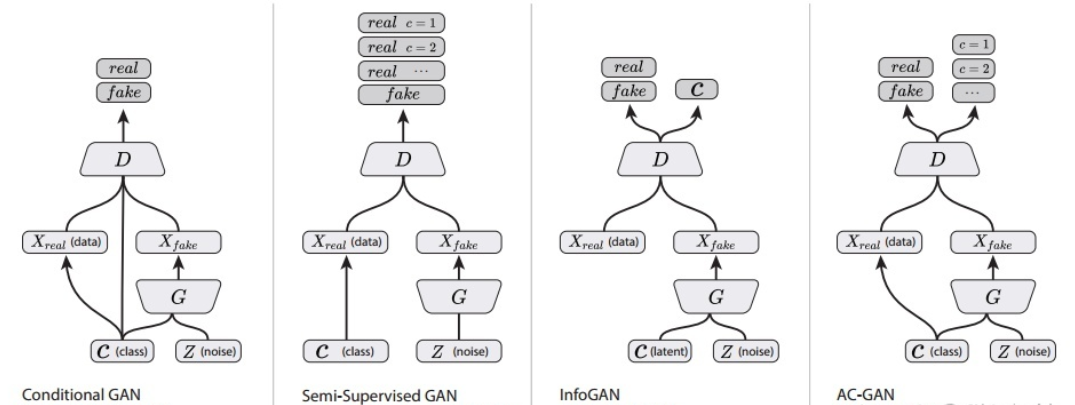

通过增加一个辅助分类器，完成一个分类任务， discriminator预测class，而不是输入class。

$$
\begin{array}{l}{L_{a d v}(D)=-\mathbb{E}_{x \sim p_{\text {data }}}[\log D(x)]-\mathbb{E}_{z \sim p_{z}, c p_{c}}[\log (1-D(G(z, c)))]} \\ {L_{c l s}(D)=\mathbb{E}_{x \sim p_{\text {data}}}\left[L_{D}\left(c_{x} | x\right)\right]}\end{array}
$$

$$
\begin{array}{l}{L_{a d v}(G)=\mathbb{E}_{z \sim p_{z}, c \sim p_{c}}[\log (1-D(G(z, c)))]} \\ {L_{c l s}(G)=\mathbb{E}_{z \sim p_{z}, c \sim p_{c}}\left[L_{D}(c | G(z, c))\right]}\end{array}
$$

即，D多计算一个分类损失。G的结构和CGAN基本一致，只是反向更新时，G会接受分类损失的梯度。

In [1]:
 # -*- coding: utf-8 -*-

import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from imageio import imread, imsave, mimsave
import cv2
import glob
from tqdm import tqdm
from utils import montage

In [ ]:
images = glob.glob('celeba/*.jpg')  # CelebA：https://link.zhihu.com/?target=http%3A//mmlab.ie.cuhk.edu.hk/projects/CelebA.html
print(len(images))

In [ ]:
# 读取标签数据
tags = {}
target = 'Male'

with open('list_attr_celeba.txt', 'r') as fr:
    lines = fr.readlines()
    all_tags = lines[0].strip('\n').split()
    for i in range(1, len(lines)):
        line = lines[i].strip('\n').split()
        if int(line[all_tags.index(target) + 1]) == 1:
            tags[line[0]] = [1, 0] # 男
        else:
            tags[line[0]] = [0, 1] # 女

print(len(tags))
print(all_tags)

In [2]:
# 使用基于WGAN的基本结构
batch_size = 100
z_dim = 100
WIDTH = 64
HEIGHT = 64
LABEL = 2
LAMBDA = 10
DIS_ITERS = 3 # 5 

OUTPUT_DIR = 'samples'
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

In [3]:
X = tf.placeholder(dtype=tf.float32, shape=[batch_size, HEIGHT, WIDTH, 3], name='X')
Y = tf.placeholder(dtype=tf.float32, shape=[batch_size, LABEL], name='Y')

# 没有y_noise，D不需要输入标签数据
noise = tf.placeholder(dtype=tf.float32, shape=[batch_size, z_dim], name='noise')

is_training = tf.placeholder(dtype=tf.bool, name='is_training')

#### layers

In [4]:
def lrelu(x, leak=0.2):
    return tf.maximum(x, leak * x)


def discriminator(image, reuse=None):
    """简单CNN、FC，输出回归预测值"""
    with tf.variable_scope('discriminator', reuse=reuse):
        h0 = lrelu(tf.layers.conv2d(image, kernel_size=5, filters=64, strides=2, padding='same'))
        h1 = lrelu(tf.layers.conv2d(h0, kernel_size=5, filters=128, strides=2, padding='same'))
        h2 = lrelu(tf.layers.conv2d(h1, kernel_size=5, filters=256, strides=2, padding='same'))
        h3 = lrelu(tf.layers.conv2d(h2, kernel_size=5, filters=512, strides=2, padding='same'))
        
        h4 = tf.contrib.layers.flatten(h3)
        # 输出增加一个Y_分支
        Y_ = tf.layers.dense(h4, units=LABEL)
        h4 = tf.layers.dense(h4, units=1)
        return h4, Y_
    
    
def generator(z, label, is_training=is_training, momentum=0.9):
    # 和CGAN相同
    with tf.variable_scope('generator', reuse=None):
        d = 4
        z = tf.concat([z, label], axis=1)
        h0 = tf.layers.dense(z, units=d * d * 512)
        h0 = tf.reshape(h0, shape=[-1, d, d, 512])
        h0 = tf.nn.relu(tf.contrib.layers.batch_norm(h0, is_training=is_training, decay=momentum))
        
        h1 = tf.layers.conv2d_transpose(h0, kernel_size=5, filters=256, strides=2, padding='same')
        h1 = tf.nn.relu(tf.contrib.layers.batch_norm(h1, is_training=is_training, decay=momentum))
        
        h2 = tf.layers.conv2d_transpose(h1, kernel_size=5, filters=128, strides=2, padding='same')
        h2 = tf.nn.relu(tf.contrib.layers.batch_norm(h2, is_training=is_training, decay=momentum))
        
        h3 = tf.layers.conv2d_transpose(h2, kernel_size=5, filters=64, strides=2, padding='same')
        h3 = tf.nn.relu(tf.contrib.layers.batch_norm(h3, is_training=is_training, decay=momentum))
        
        h4 = tf.layers.conv2d_transpose(h3, kernel_size=5, filters=3, strides=2, padding='same', activation=tf.nn.tanh, name='g')
        return h4

#### Graph

In [ ]:
g = generator(noise, Y)
d_real, y_real = discriminator(X)
d_fake, y_fake = discriminator(g, reuse=True)

loss_d_real = -tf.reduce_mean(d_real)
loss_d_fake = tf.reduce_mean(d_fake)

# 增加class预测损失，是回归方法计算损失，效果相对较好
loss_cls_real = tf.losses.mean_squared_error(Y, y_real)
loss_cls_fake = tf.losses.mean_squared_error(Y, y_fake)

loss_d = loss_d_real + loss_d_fake + loss_cls_real
loss_g = -tf.reduce_mean(d_fake) + loss_cls_fake

# gradient penalty
# 对真实图片和生成图片进行线性插值
alpha = tf.random_uniform(shape=[batch_size, 1, 1, 1], minval=0., maxval=1.)
interpolates = alpha * X + (1 - alpha) * g

# 用偏导数计算整体梯度（slop）
grad = tf.gradients(discriminator(interpolates, reuse=True), [interpolates])[0]
slop = tf.sqrt(tf.reduce_sum(tf.square(grad), axis=[1]))
gp = tf.reduce_mean((slop - 1.) ** 2)
loss_d += LAMBDA * gp

# 分别建立生成器和判别器的BP计算路径
vars_g = [var for var in tf.trainable_variables() if var.name.startswith('generator')]
vars_d = [var for var in tf.trainable_variables() if var.name.startswith('discriminator')]

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer_d = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5).minimize(loss_d, var_list=vars_d)
    optimizer_g = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5).minimize(loss_g, var_list=vars_g)

#### utils

In [ ]:
# 输入数据处理
X_all = []
Y_all = []
for i in tqdm(range(len(images))):
    image = imread(images[i])
    h = image.shape[0]
    w = image.shape[1]
    if h > w:
        image = image[h // 2 - w // 2: h // 2 + w // 2, :, :]
    else:
        image = image[:, w // 2 - h // 2: w // 2 + h // 2, :]    
    image = cv2.resize(image, (WIDTH, HEIGHT))
    image = (image / 255. - 0.5) * 2
    X_all.append(image)
    
    image_name = images[i][images[i].find('/') + 1:]
    Y_all.append(tags[image_name])

X_all = np.array(X_all)
Y_all = np.array(Y_all)
print(X_all.shape, Y_all.shape)

In [ ]:
def get_random_batch():
    data_index = np.arange(X_all.shape[0])
    np.random.shuffle(data_index)
    data_index = data_index[:batch_size]
    
    X_batch = X_all[data_index, :, :, :]
    Y_batch = Y_all[data_index, :]
    
    return X_batch, Y_batch

#### train

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
zs = np.random.uniform(-1.0, 1.0, [batch_size // 2, z_dim]).astype(np.float32)
z_samples = []
y_samples = []

# 男，女相邻生成
for i in range(batch_size // 2):
    z_samples.append(zs[i, :])
    y_samples.append([1, 0])
    z_samples.append(zs[i, :])
    y_samples.append([0, 1])

samples = []
loss = {'d': [], 'g': []}

for i in tqdm(range(60000)):
    for j in range(DIS_ITERS):
        n = np.random.uniform(-1.0, 1.0, [batch_size, z_dim]).astype(np.float32)
        X_batch, Y_batch = get_random_batch()
        _, d_ls = sess.run([optimizer_d, loss_d], feed_dict={X: X_batch, Y: Y_batch, noise: n, is_training: True})
    
    _, g_ls = sess.run([optimizer_g, loss_g], feed_dict={X: X_batch, Y: Y_batch, noise: n, is_training: True})
    
    loss['d'].append(d_ls)
    loss['g'].append(g_ls)
    
    if i % 500 == 0:
        print(i, d_ls, g_ls)
        gen_imgs = sess.run(g, feed_dict={noise: z_samples, Y: y_samples, is_training: False})
        gen_imgs = (gen_imgs + 1) / 2
        imgs = [img[:, :, :] for img in gen_imgs]
        gen_imgs = montage(imgs)
        plt.axis('off')
        plt.imshow(gen_imgs)
        imsave(os.path.join(OUTPUT_DIR, 'sample_%d.jpg' % i), gen_imgs)
        plt.show()
        samples.append(gen_imgs)
        
saver = tf.train.Saver()
saver.save(sess, './celeba_acgan', global_step=60000)

plt.plot(loss['d'], label='Discriminator')
plt.plot(loss['g'], label='Generator')
plt.legend(loc='upper right')
plt.savefig('Loss.png')
plt.show()
mimsave(os.path.join(OUTPUT_DIR, 'samples.gif'), samples, fps=10)

#### test

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from utils import montage

tf.__version__

batch_size = 100
z_dim = 100
LABEL = 2

##### 由女变男转换（固定噪音，渐变条件）

In [3]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

saver = tf.train.import_meta_graph('./celeba_acgan-60000.meta')
saver.restore(sess, tf.train.latest_checkpoint('./'))

graph = tf.get_default_graph()
g = graph.get_tensor_by_name('generator/g/Tanh:0')
noise = graph.get_tensor_by_name('noise:0')
Y = graph.get_tensor_by_name('Y:0')
is_training = graph.get_tensor_by_name('is_training:0')

INFO:tensorflow:Restoring parameters from ./celeba_acgan-60000


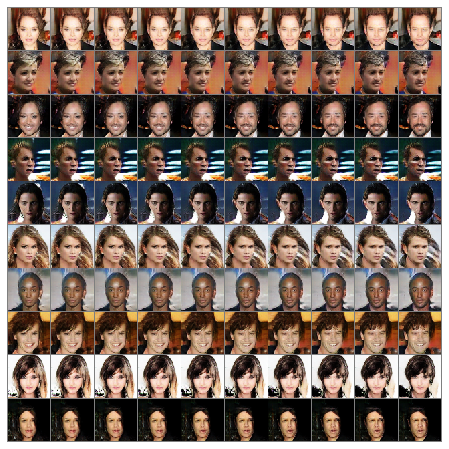

In [13]:
n = np.random.uniform(-1.0, 1.0, [10, z_dim]).astype(np.float32)
ns = []
y_samples = []

# [男，女]label的渐变。（D使用回归预测y）
for i in range(100):
    ns.append(n[i // 10, :])
    y_samples.append([i % 10 / 9, 1 - i % 10 / 9])
    
gen_imgs = sess.run(g, feed_dict={noise: ns, Y: y_samples, is_training: False})
gen_imgs = (gen_imgs + 1) / 2
imgs = [img[:, :, :] for img in gen_imgs]
gen_imgs = montage(imgs)
gen_imgs = np.clip(gen_imgs, 0, 1)

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(gen_imgs)
plt.show()

##### 由脸到脸转换（固定条件，渐变噪声）

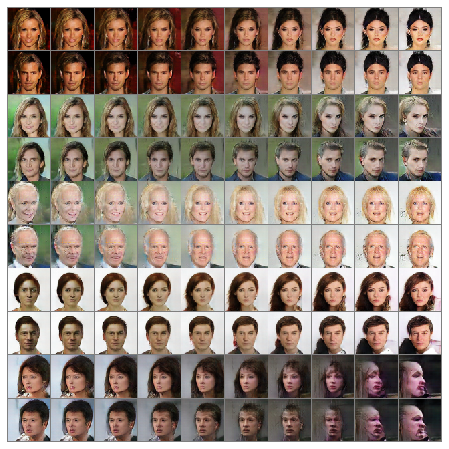

In [18]:
n = np.random.uniform(-1.0, 1.0, [5, 2, z_dim]).astype(np.float32)

ns = []
y_samples = []

for i in range(5):
    for k in range(2):  # 男一行，女一行
        for j in range(10):  #  10张图片 
            start = n[i, 0, :]
            end = n[i, 1, :]
            ns.append(start + j * (end - start) / 9)
            if k == 0:
                y_samples.append([0, 1])
            else:
                y_samples.append([1, 0])

gen_imgs = sess.run(g, feed_dict={noise: ns, Y: y_samples, is_training: False})
gen_imgs = (gen_imgs + 1) / 2
imgs = [img[:, :, :] for img in gen_imgs]
gen_imgs = montage(imgs)
gen_imgs = np.clip(gen_imgs, 0, 1)

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(gen_imgs)
plt.show()